In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

testSet = []
testCoords = []

In [4]:

def evaluate_individual_performances(outputPath, trainSetCoordsPath, testSetCoordsPath, aruco, train_test_data):

    global testSet, testCoords
    # aruco = np.array(aruco)
    # m_id = str(aruco[0])
    m_id = aruco
    # Regression Degree
    DEG = 2

    # Train Set
    # Slow Feature Values
    trainSetPath = outputPath + '/Evaluation_Arrays/' + 'train_'+m_id+'_slowFeatures.npy'

    # Marker detection results
    detectionResultsTrainSetPath = outputPath + '/' + 'result_train.csv'

    # Load Files
    trainSet = np.load(trainSetPath)
    trainSetCoords = np.loadtxt(trainSetCoordsPath, delimiter=',', usecols=(4, 5))
    # trainSetCoords = np.loadtxt(trainSetCoordsPath)[:, 0:2]
    detectionResultsTrainSet = pd.read_csv(detectionResultsTrainSetPath)

    markerSquaresTrainSet = detectionResultsTrainSet[
        [m_id + '_bb_x1', m_id + '_bb_y1', m_id + '_bb_x2', m_id + '_bb_y2', m_id + '_bb_x3', m_id + '_bb_y3', m_id +
         '_bb_x4', m_id + '_bb_y4']].values

    # Keep only the coordinates with valid marker detection (Train/Test Set)
    trainCoords = []
    for i in range(trainSetCoords.shape[0]):
        if markerSquaresTrainSet[i].sum() != 0:
            trainCoords.append(trainSetCoords[i, :])
    trainCoords = np.array(trainCoords)

    print("\nActual coordinates\n ")
    print("Train Set: (%d,%d) " % trainSetCoords.shape)
    print("Train Set after marker detection: (%d,%d) " % trainCoords.shape)

    # Test set
    if train_test_data:
        testSetPath = outputPath + '/Evaluation_Arrays/' + 'test_'+m_id+'_slowFeatures.npy'
        detectionResultsTestSetPath = outputPath + '/' + 'result_test.csv'
        testSet = np.load(testSetPath)
        testSetCoords = np.loadtxt(testSetCoordsPath, delimiter=',', usecols=(4, 5))
        # testSetCoords = np.loadtxt(testSetCoordsPath)[:, 0:2]
        detectionResultsTestSet = pd.read_csv(detectionResultsTestSetPath)
        markerSquaresTestSet = detectionResultsTestSet[
            [m_id + '_bb_x1', m_id + '_bb_y1', m_id + '_bb_x2', m_id + '_bb_y2', m_id + '_bb_x3', m_id + '_bb_y3',
             m_id +
             '_bb_x4', m_id + '_bb_y4']].values
        testCoords = []
        for i in range(testSetCoords.shape[0]):
            if markerSquaresTestSet[i].sum() != 0:
                testCoords.append(testSetCoords[i, :])
        testCoords = np.array(testCoords)
        print("Test Set: (%d,%d) " % testSetCoords.shape)
        print("Test Set  after marker detection: (%d,%d) " % testCoords.shape)

    # Perform Regression
    #####################################################
    polyRegressor = PolynomialFeatures(degree=DEG)
    fig, ax = plt.subplots()

    if train_test_data:
        polyFeatureTrainingSet = polyRegressor.fit_transform(trainSet)
        polyFeaturesTestSet = polyRegressor.fit_transform(testSet)

        regressor_x = LinearRegression()
        regressor_x.fit(polyFeatureTrainingSet, trainCoords[:, 0])  # x-coordinates

        regressor_y = LinearRegression()
        regressor_y.fit(polyFeatureTrainingSet, trainCoords[:, 1])  # y-coordinates

        predicted_X = regressor_x.predict(polyFeaturesTestSet)
        predicted_Y = regressor_y.predict(polyFeaturesTestSet)

        prediction_X = predicted_X.reshape(predicted_X.shape[0], 1)
        prediction_Y = predicted_Y.reshape(predicted_Y.shape[0], 1)
        predictedCoordinates = np.hstack([prediction_X, prediction_Y])
        # Calculate Error
        ######################################################
        MAE = mean_absolute_error(testCoords, predictedCoordinates)
        print("\nMean Absolute Error: %f [m]\n" % MAE)
        # Visualize
        ######################################################
        ax.plot(testCoords[:, 0], testCoords[:, 1], 'b.', lw=1, label='Ground truth')
        ax.plot(prediction_X, prediction_Y, 'r.', lw=1, label='Estimation')

    else:
        polyFeatureTrainingSet = polyRegressor.fit_transform(trainSet)
        # polyFeaturesTestSet = polyRegressor.fit_transform(testSet)

        X_train, X_test, y_train, y_test = train_test_split(polyFeatureTrainingSet, trainCoords, test_size=0.33,
                                                            random_state=42)

        regressor_x = LinearRegression()
        regressor_x.fit(X_train, y_train[:, 0])  # x-coordinates

        regressor_y = LinearRegression()
        regressor_y.fit(X_train, y_train[:, 1])  # y-coordinates

        predicted_X = regressor_x.predict(X_test)
        predicted_Y = regressor_y.predict(X_test)

        prediction_X = predicted_X.reshape(predicted_X.shape[0], 1)
        prediction_Y = predicted_Y.reshape(predicted_Y.shape[0], 1)
        predictedCoordinates = np.hstack([prediction_X, prediction_Y])

        MAE = mean_absolute_error(y_test, predictedCoordinates)
        print("\nMean Absolute Error: %f [m]\n" % MAE)

        ax.plot(y_test[:, 0], y_test[:, 1], 'b.', lw=1, label='Ground truth')
        ax.plot(prediction_X, prediction_Y, 'r.', lw=1, label='Estimation')

    plt.title('Mean Absolute Error: ' + "{:.2f}".format(MAE), fontweight='bold')
    legend = ax.legend(loc='lower right', shadow=True)
    plt.xlabel('X [m]', fontsize=16)
    plt.ylabel('Y [m]', fontsize=16)
    plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
    plt.rc('font', weight='bold')
    plt.rc('legend', **{'fontsize': 8})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tick_params(labelsize=12)
    plt.savefig(outputPath + '/' + 'marker_'+m_id+'_result.jpg', dpi=1200, bbox_inches='tight')  # Save?
    plt.show()



In [7]:
outputPath = '/hri/localdisk/ThesisProject/Kaushik/Kaushik/Testing_Sample_Script/06032020-163049/'
trainSetCoordsPath = '/hri/localdisk/ThesisProject/Kaushik/Kaushik/Testing_Sample_Script/06032020-163049/coordinates_train.txt'
testSetCoordsPath = '/hri/localdisk/ThesisProject/Kaushik/Kaushik/Testing_Sample_Script/06032020-163049/coordinates_test.txt'
aruco = '160'
train_test_data = True


Actual coordinates
 
Train Set: (1282,2) 
Train Set after marker detection: (1090,2) 
Test Set: (906,2) 
Test Set  after marker detection: (848,2) 

Mean Absolute Error: 0.636446 [m]



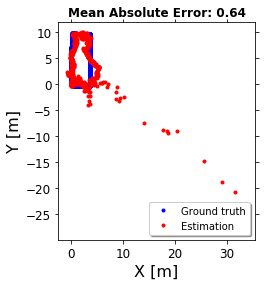

In [8]:

evaluate_individual_performances(outputPath, trainSetCoordsPath, testSetCoordsPath, aruco, train_test_data)